In [0]:
import cv2
from pathlib import Path
import xml.etree.ElementTree as ET 
import random
from scipy import ndimage
import imgaug as ia
import imgaug.augmenters as iaa
from PIL import Image
import re 

In [0]:
import glob
import numpy as np
import pandas as pd
import os
import shutil 
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

import sys

sys.path.insert(1, '/content/drive/My Drive/ladd')

from data_utils.ImageDataAugmentor import *
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose
)
import tqdm

from keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tqdm import tqdm


In [0]:
WIDTH = 224
HEIGHT = 224
BATCH_SIZE = 32
   
TRAIN_AUGMENTATIONS = Compose([
        RandomRotate90(),
        Flip(),
        Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomBrightnessContrast(),            
        ], p=0.3),
        HueSaturationValue(p=0.3),
    ], p=0.5)



train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    #brightness_range=(0.9, 1.05),
    #channel_shift_range=5.0,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory('/content/drive/My Drive/ladd/clean/train/', target_size=(WIDTH,HEIGHT), batch_size=BATCH_SIZE,class_mode='binary')
validation_generator = validation_datagen.flow_from_directory('/content/drive/My Drive/ladd/clean/val/', target_size=(WIDTH,HEIGHT), batch_size=BATCH_SIZE,class_mode='binary')

Found 4754 images belonging to 2 classes.
Found 1358 images belonging to 2 classes.


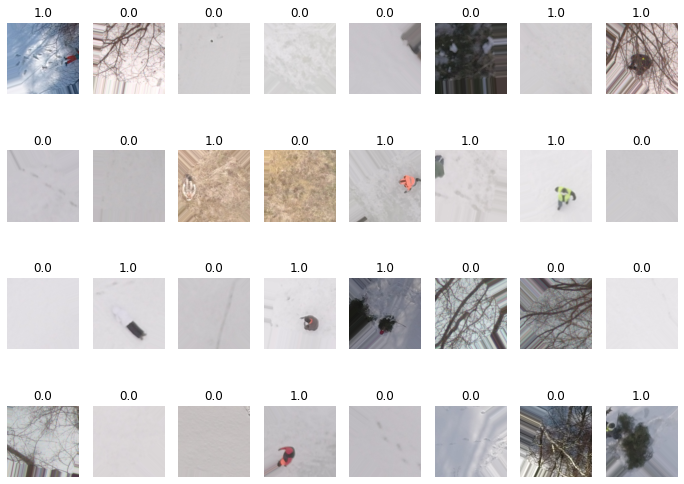

In [0]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.title(lbl)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

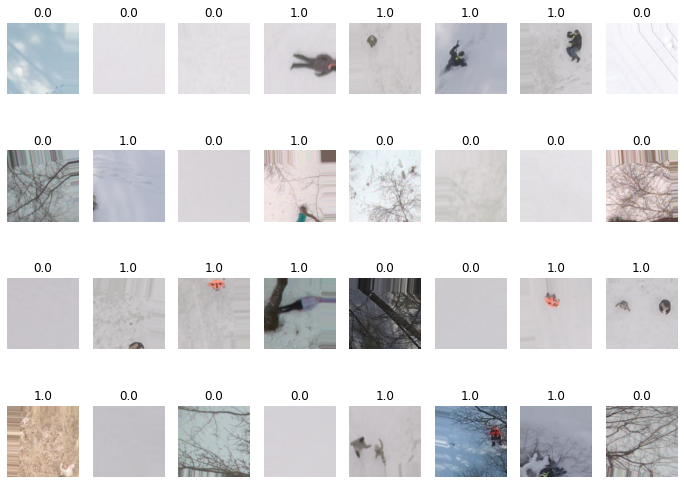

In [0]:
x_batch, y_batch = next(validation_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.title(lbl)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

In [0]:
restnet50 = ResNet50V2(include_top=False,pooling='max', weights='imagenet', input_shape=(HEIGHT,WIDTH,3))

In [0]:


for layer in restnet50.layers:
    layer.trainable = False

restnet50.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [0]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
import keras.backend as K
import tensorflow as tf

def binary_focal_loss(gamma=2.0, alpha=0.25):
    """
    Implementation of Focal Loss from the paper in multiclass classification
    Formula:
        loss = -alpha_t*((1-p_t)^gamma)*log(p_t)
        
        p_t = y_pred, if y_true = 1
        p_t = 1-y_pred, otherwise
        
        alpha_t = alpha, if y_true=1
        alpha_t = 1-alpha, otherwise
        
        cross_entropy = -log(p_t)
    Parameters:
        alpha -- the same as wighting factor in balanced cross entropy
        gamma -- focusing parameter for modulating factor (1-p)
    Default value:
        gamma -- 2.0 as mentioned in the paper
        alpha -- 0.25 as mentioned in the paper
    """
    def focal_loss(y_true, y_pred):
        # Define epsilon so that the backpropagation will not result in NaN
        # for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        #y_pred = y_pred + epsilon
        # Clip the prediciton value
        y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
        # Calculate p_t
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1-y_pred)
        # Calculate alpha_t
        alpha_factor = K.ones_like(y_true)*alpha
        alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1-alpha_factor)
        # Calculate cross entropy
        cross_entropy = -K.log(p_t)
        weight = alpha_t * K.pow((1-p_t), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.sum(loss, axis=1)
        return loss
    
    return focal_loss    

In [0]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
import keras

model = restnet50.output
model = Dense(1000, activation='relu')(model)
model = Dense(512, activation='relu')(model)
model = Dense(1, activation='sigmoid')(model)

model = Model(inputs=restnet50.input, outputs=model)

model.compile(loss=binary_focal_loss(),
              optimizer=optimizers.Adam(learning_rate=0.00001),
              metrics=['accuracy',f1_m,precision_m, recall_m])
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
___________________________________________________________________________________________

In [106]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    mode='min',
    verbose=1)

checkpoint = ModelCheckpoint(
    'model_best_weights_2.h5',
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    period=5)

history = model.fit_generator(train_generator, 
                              steps_per_epoch=1000, 
                              epochs=10,
                              validation_data=validation_generator, 
                              validation_steps=500, 
                              verbose=1,
                              callbacks = [checkpoint])

Epoch 1/10
1000/1000 [==============================] - 615s 615ms/step - loss: 0.0799 - accuracy: 0.8904 - f1_m: 0.8815 - precision_m: 0.9316 - recall_m: 0.8463 - val_loss: 0.2100 - val_accuracy: 0.9403 - val_f1_m: 0.9391 - val_precision_m: 0.9314 - val_recall_m: 0.9507
Epoch 2/10
1000/1000 [==============================] - 611s 611ms/step - loss: 0.0413 - accuracy: 0.9251 - f1_m: 0.9221 - precision_m: 0.9584 - recall_m: 0.8948 - val_loss: 0.0279 - val_accuracy: 0.9504 - val_f1_m: 0.9478 - val_precision_m: 0.9676 - val_recall_m: 0.9320
Epoch 3/10
1000/1000 [==============================] - 610s 610ms/step - loss: 0.0337 - accuracy: 0.9269 - f1_m: 0.9237 - precision_m: 0.9607 - recall_m: 0.8954 - val_loss: 0.0317 - val_accuracy: 0.9504 - val_f1_m: 0.9487 - val_precision_m: 0.9581 - val_recall_m: 0.9430
Epoch 4/10
1000/1000 [==============================] - 615s 615ms/step - loss: 0.0281 - accuracy: 0.9319 - f1_m: 0.9284 - precision_m: 0.9635 - recall_m: 0.9011 - val_loss: 0.0050 - v

In [0]:
.model.save('model_best_weights.h5')

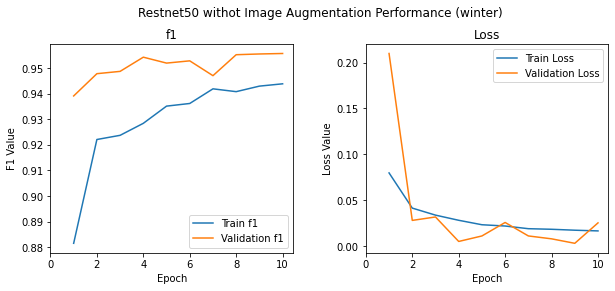

In [107]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
t = f.suptitle('Restnet50 withot Image Augmentation Performance (winter)', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,11))
ax1.plot(epoch_list, history.history['f1_m'], label='Train f1')
ax1.plot(epoch_list, history.history['val_f1_m'], label='Validation f1')
ax1.set_xticks(np.arange(0, 12, 2))
ax1.set_ylabel('F1 Value')
ax1.set_xlabel('Epoch')
ax1.set_title('f1')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 12, 2))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [108]:
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory('/content/drive/My Drive/ladd/test_sum', target_size=(WIDTH,HEIGHT), batch_size=BATCH_SIZE,class_mode='binary')

Found 144 images belonging to 2 classes.


In [109]:
score=model.evaluate(test_generator)
print(score)

5/5 [==============================] - 109s 22s/step
[0.027399063110351562, 0.9305555820465088, 0.9211204648017883, 0.9777777791023254, 0.8733333349227905]


In [110]:
model.metrics_names

['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m']